# 课时31 卫星图像识别 卷积综合实例——图片数据处理

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
sb.set_style('darkgrid')
# pathlib相比os.path更好用
import pathlib
import random
import matplotlib.pyplot as plt
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.4.0


# 1. 导入数据

In [2]:
data_dir = '/Users/stoner/Documents/VScode/TensorFlow-2.0-Tutorial/TF2_dataset/2_class'
data_root = pathlib.Path(data_dir)
data_root

PosixPath('/Users/stoner/Documents/VScode/TensorFlow-2.0-Tutorial/TF2_dataset/2_class')

In [3]:
for item in data_root.iterdir():
    print(item)

/Users/stoner/Documents/VScode/TensorFlow-2.0-Tutorial/TF2_dataset/2_class/lake
/Users/stoner/Documents/VScode/TensorFlow-2.0-Tutorial/TF2_dataset/2_class/airplane


In [4]:
# 取出所有图片的路径, */*代表所有路径下的所有对象
# data_root.glob('*/*')得到的是一个可迭代对象，因此需要用list将其转换为列表元素
all_image_path = list(data_root.glob('*/*'))
len(all_image_path)

1400

In [6]:
# 由于上面获取到的路径是WindowsPath对象，所以需要将其转换为正式的路径
all_image_path = [str(path) for path in all_image_path]
all_image_path[:3]

['/Users/stoner/Documents/VScode/TensorFlow-2.0-Tutorial/TF2_dataset/2_class/lake/lake_008.jpg',
 '/Users/stoner/Documents/VScode/TensorFlow-2.0-Tutorial/TF2_dataset/2_class/lake/lake_020.jpg',
 '/Users/stoner/Documents/VScode/TensorFlow-2.0-Tutorial/TF2_dataset/2_class/lake/lake_034.jpg']

In [7]:
# 对数据集进行乱序
random.shuffle(all_image_path)

In [8]:
# 记录数据集的总的个数，方便后续对数据进行训练集和测试集的划分
image_count = len(all_image_path)

In [9]:
# 获取标签, data_root.glob('*/')代表取出所有的目录名(这里是二分类，也就两个目录，也就是两个标签)
labels_name = sorted(item.name for item in data_root.glob('*/'))
# 将标签转换为数值
labels_to_index = dict((name, index) for index, name in enumerate(labels_name))
labels_to_index

{'airplane': 0, 'lake': 1}

In [10]:
# 获取所有图片对应的标签：获取每张图片的路径的上一级路径，然后根据labels_name得到对应的数值标签
# 以下面为例：
pathlib.Path(all_image_path[3]).parent.name
all_image_label = [labels_to_index[pathlib.Path(p).parent.name] for p in all_image_path]

In [11]:
# 获得对应的index_to_label
import IPython.display as display
index_to_label = dict((value, key) for key,value in labels_to_index.items())
index_to_label

{0: 'airplane', 1: 'lake'}

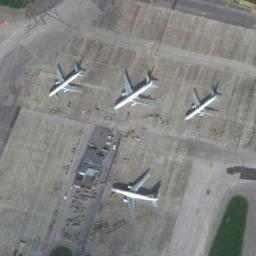

airplane



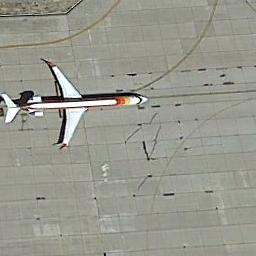

airplane



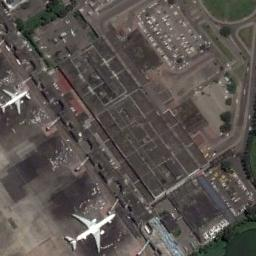

airplane



In [12]:
# 这里是随机展示三张图片
for i in range(3):
    image_index = random.choice(range(len(all_image_path)))
    display.display(display.Image(all_image_path[image_index]))
    print(index_to_label[all_image_label[image_index]])
    print()

In [13]:
# 这里是示例如何实用TensorFlow读取一张图片
image_path = all_image_path[0]
# 1. 读取指定路径的图片，得到图片二进制数据
image_raw = tf.io.read_file(image_path)
# 2. 对图片的二进制数据进行解码(image_tensor.dtype=tf.uint8)
image_tensor = tf.image.decode_image(image_raw)
# 3. 将图片解码后得到的数据类型从uint8类型转换成float32类型
image_tensor = tf.cast(image_tensor, tf.float32)
# 4. 对图片数据进行归一化
image_tensor = image_tensor / 255
image_tensor.numpy().max()

0.3372549

In [14]:
# 将上面的步骤写成一个函数
def load_preprocess_image(image_path):
    image_raw = tf.io.read_file(image_path)
    # image_tensor = tf.image.decode_image(image_raw)
    # 需要注意的是decode_image函数是一种通用的解析图片的方式，但是解析之后的图片的shape是不明确的
    # 因此需要使用对应的图片格式的解析函数，这里图片都是jpg的，因此使用下面的方式：
    image_tensor = tf.image.decode_jpeg(image_raw, channels=3)
    # 然后使用resize方法将图片转换成正确的形状大小
    image_tensor = tf.image.resize(image_tensor, size=[256, 256])
    image_tensor = tf.cast(image_tensor, tf.float32)
    image = image_tensor / 255
    return image

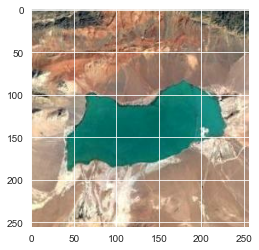

In [15]:
plt.imshow(load_preprocess_image(all_image_path[100]))

# 2. 构造数据的tf_Dataset以及数据集划分

In [16]:
# 路径字符串数据构造成Dataset
path_dataset = tf.data.Dataset.from_tensor_slices(all_image_path)
# 使用map函数构造图片images的Dataste
images_dataset = path_dataset.map(load_preprocess_image)
# 构造标签数据的Dataset
labels_dataset = tf.data.Dataset.from_tensor_slices(all_image_label)
# 将图片Dataset和标签Dataset进行合并
dataset = tf.data.Dataset.zip((images_dataset, labels_dataset))
dataset

<ZipDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

In [17]:
# 划分训练集和测试集
test_count = int(image_count * 0.2)
train_count = image_count - test_count
# 训练集(使用Dataset的.skip方法可实现)
train_dataset = dataset.skip(test_count)
# 测试集
test_dataset = dataset.take(test_count)
# 设定batch_size大小
BATCH_SIZE = 32
# 对训练集进行打乱和batch划分操作(repeat没有写的时候代表默认情况下无限重复)
train_dataset = train_dataset.shuffle(buffer_size=image_count).batch(batch_size=BATCH_SIZE)
# 对测试机进行batch划分
test_dataset = test_dataset.batch(batch_size=BATCH_SIZE)

# 3. 卷积网络搭建和训练

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                           input_shape=(256, 256, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=1024),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])
# model.summary()
tf.keras.utils.plot_model(model, "./model.jpg", show_shapes=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = test_count // BATCH_SIZE
history = model.fit(train_dataset, epochs=5, steps_per_epoch=steps_per_epoch,  
                    validation_data=test_dataset, validation_steps=validation_steps)

In [ ]:
history.history.keys()